In [13]:
import numpy as np
import matplotlib.pyplot as plt

from gdmate.io import pyvista_io
from gdmate.analysis_modules import particles
from gdmate.visualization import pyvista_vis

In [14]:
directory = r'/mnt/15c59731-2c7b-420d-8e97-048239b4d9c8/riftinversion_overflow/071822_rip_b/output_ri_rift/particles'
length = 56
interval = 0.1
start = length-20
tsteps = np.arange(int(start/interval),int(length/interval+1),1)
tsteps_small = np.arange(360,460,1)

In [15]:
bounds = [400e3,600e3,550e3,620e3,0,0]
field = 'initial crust_lower'

meshes = pyvista_io.pv_load_clipped_meshes(directory,tsteps_small,bounds=bounds,
    field=field,value=0.9,kind='particles',processes=4)

Loading and Clipping Meshes...
Processes:  4


100%|██████████| 100/100 [10:13<00:00,  6.14s/it]OStream.flush timed out



In [19]:
left_side = meshes[0].points[:,0]<525e3

meshes[0]['rift_side'] = left_side

In [20]:
particles.run_scalar_forward(meshes[0],meshes[1:],field='rift_side')

100%|██████████| 134046/134046 [00:16<00:00, 8328.82it/s] 


MultiBlock (0x7f7f10ba8ac0)
  N Blocks:	99
  X Bounds:	400000.000, 600000.000
  Y Bounds:	550000.125, 594321.062
  Z Bounds:	0.000, 0.000

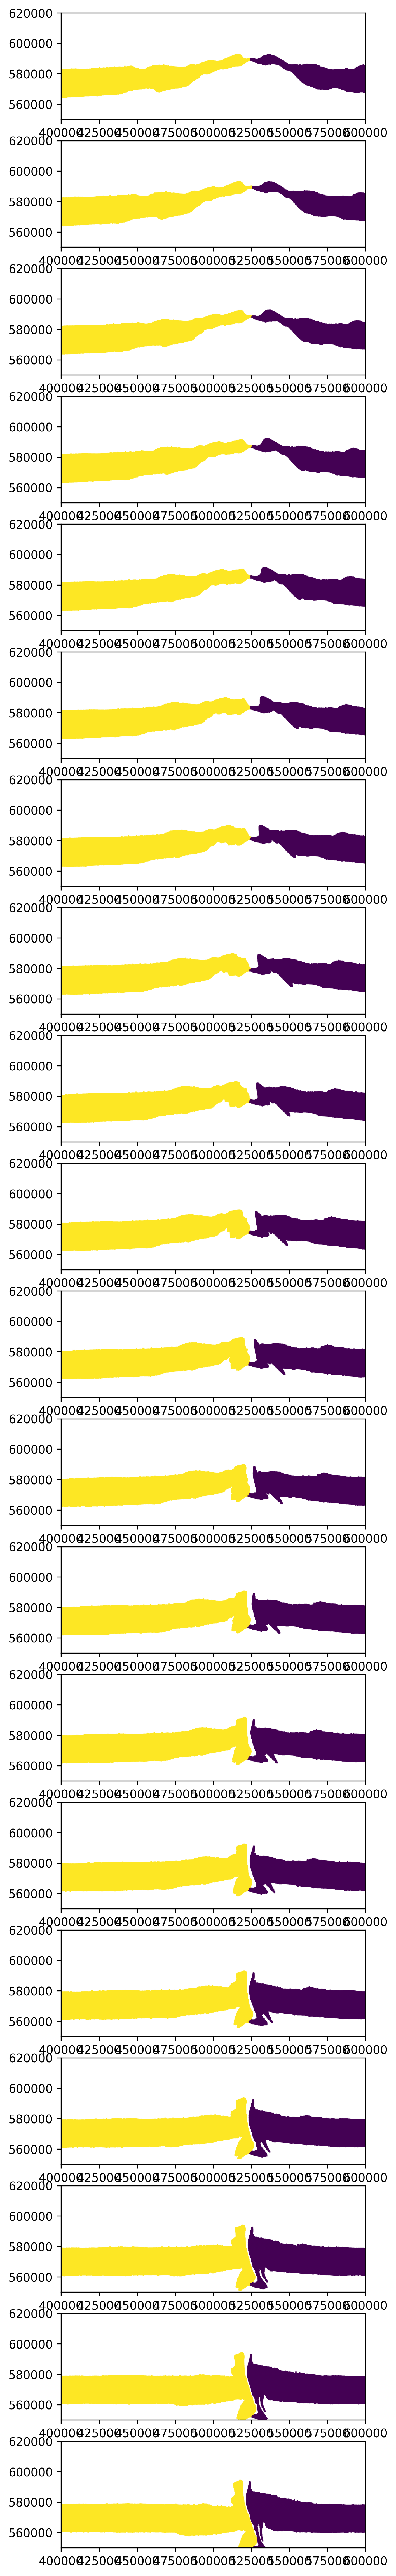

In [21]:
fig,axs = plt.subplots(int(len(meshes)/5),dpi=300,figsize=(8.5,2*len(meshes)/5))

for k,ax in enumerate(axs):
    pyvista_vis.pv_plot_2d(meshes[k*5],'rift_side',bounds=bounds[0:4],ax=ax)